In [1]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression


In [2]:
# 2. Đọc file dữ liệu chứng khoán AAPL và chia train test validate theo tỉ lệ 7:2:1
df = pd.read_csv('../../../Data/BNB-USD.csv')
df['Close'] = df['Close']
print(df)

df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index

# Split the data into training, testing, and validation sets
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

train_data = df['Close'].iloc[:train_size]
test_data = df['Close'].iloc[train_size:train_size+test_size]
val_data = df['Close'].iloc[train_size+test_size:]

            Date        Open        High         Low       Close   Adj Close  \
0      11/9/2017    2.053140    2.174230    1.893940    1.990770    1.990770   
1     11/10/2017    2.007730    2.069470    1.644780    1.796840    1.796840   
2     11/11/2017    1.786280    1.917750    1.614290    1.670470    1.670470   
3     11/12/2017    1.668890    1.672800    1.462560    1.519690    1.519690   
4     11/13/2017    1.526010    1.735020    1.517600    1.686620    1.686620   
...          ...         ...         ...         ...         ...         ...   
2039   6/10/2023  260.698669  260.716095  233.169189  239.089081  239.089081   
2040   6/11/2023  239.087418  239.348267  234.430695  235.438797  235.438797   
2041   6/12/2023  235.403915  238.473221  222.071335  231.051437  231.051437   
2042   6/13/2023  231.075043  245.642197  229.311691  243.890533  243.890533   
2043   6/14/2023  243.890533  251.630157  234.042557  237.574265  237.574265   

          Volume  
0       19192200  
1

In [3]:
# 3. Quá trình Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data)

# Find the best ARIMA model using auto_arima
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=11037.402, Time=0.93 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=11125.874, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=11081.671, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=11090.789, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=11124.740, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=11055.398, Time=0.35 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=11064.236, Time=0.36 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=11035.189, Time=1.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=11061.667, Time=0.39 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=11020.134, Time=1.48 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=11044.072, Time=0.76 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=11023.037, Time=1.44 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=11017.147, Time=1.91 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=11020.733, Time=1.47 sec
 ARIMA(5,1,3)(0,0,0

ARIMA(order=(5, 1, 5), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [4]:
# 4. Quá trình testing
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data)
y_pred = model.predict(n_periods=len(y_test))

# 5. Quá trình Validate
x_val= np.array(val_data.index).reshape(-1, 1)
y_val = np.array(val_data)
y_pred_val =  model.predict(n_periods=len(y_val))

In [5]:
# 6. Quá trình tạo index predict 30 ngày tiếp theo
last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Predict the closing prices for the next 30 days
y_next_30_days = model.predict(n_periods=len(x_next_30_days))

# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[430.09812335 430.16455842 431.22645355 432.89803331 436.21679481
 428.40948401 425.20713054 426.12546377 426.93395576 426.309717
 431.71799653 434.8802851  432.67352772 429.79889633 429.11995263
 426.1292622  424.47985435 427.48029037 431.2196751  431.99168534
 432.60397908 432.46547544 429.34217954 426.01002037 425.98758967
 427.33826777 428.74348585 431.23857253 433.25853769 432.22614063]


In [6]:
# 7. Đánh giá độ chính xác validate, test
from sklearn.metrics import mean_absolute_percentage_error, explained_variance_score
# RMSE
rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print("The root mean squared error (RMSE) on test set: {:.3f}".format(rmse))
# EVS
evs = explained_variance_score(test_data, y_pred)
print("The explained variance score (EVS) on test set: {:.3f}".format(evs))
#MAPE
mape = mean_absolute_percentage_error(test_data, y_pred)
print("The mean absolute percentage error (MAPE) on test set: {:.3f}".format(mape))

The root mean squared error (RMSE) on test set: 124.531
The explained variance score (EVS) on test set: 0.000
The mean absolute percentage error (MAPE) on test set: 0.339


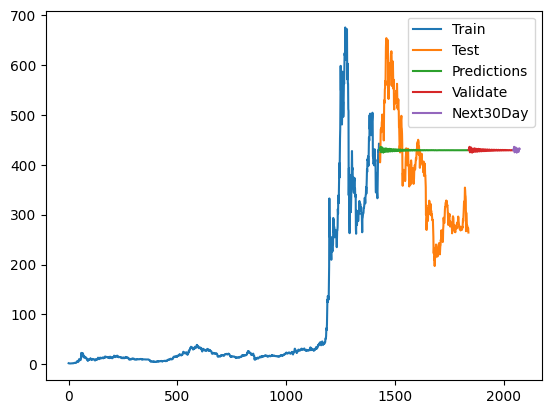

In [7]:
# 9.Vẽ hình
plt.plot(train_data.index, train_data)
plt.plot(test_data.index, test_data)
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_pred_val)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.show()

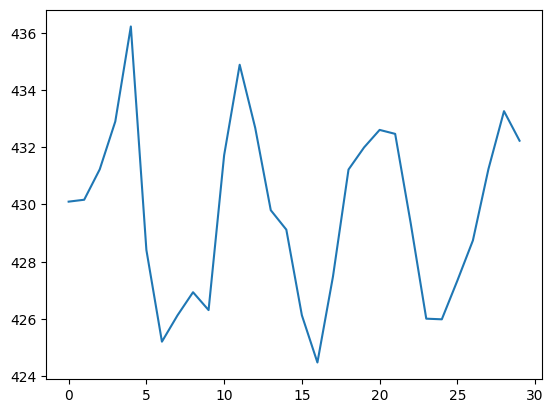

In [10]:
plt.plot(y_next_30_days)
